In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import matplotlib.ticker as ticker
import re, glob

# Plot energy norm for IMEX-RB on 2D nonlinear problem
We show absolute stability of IMEX-RB

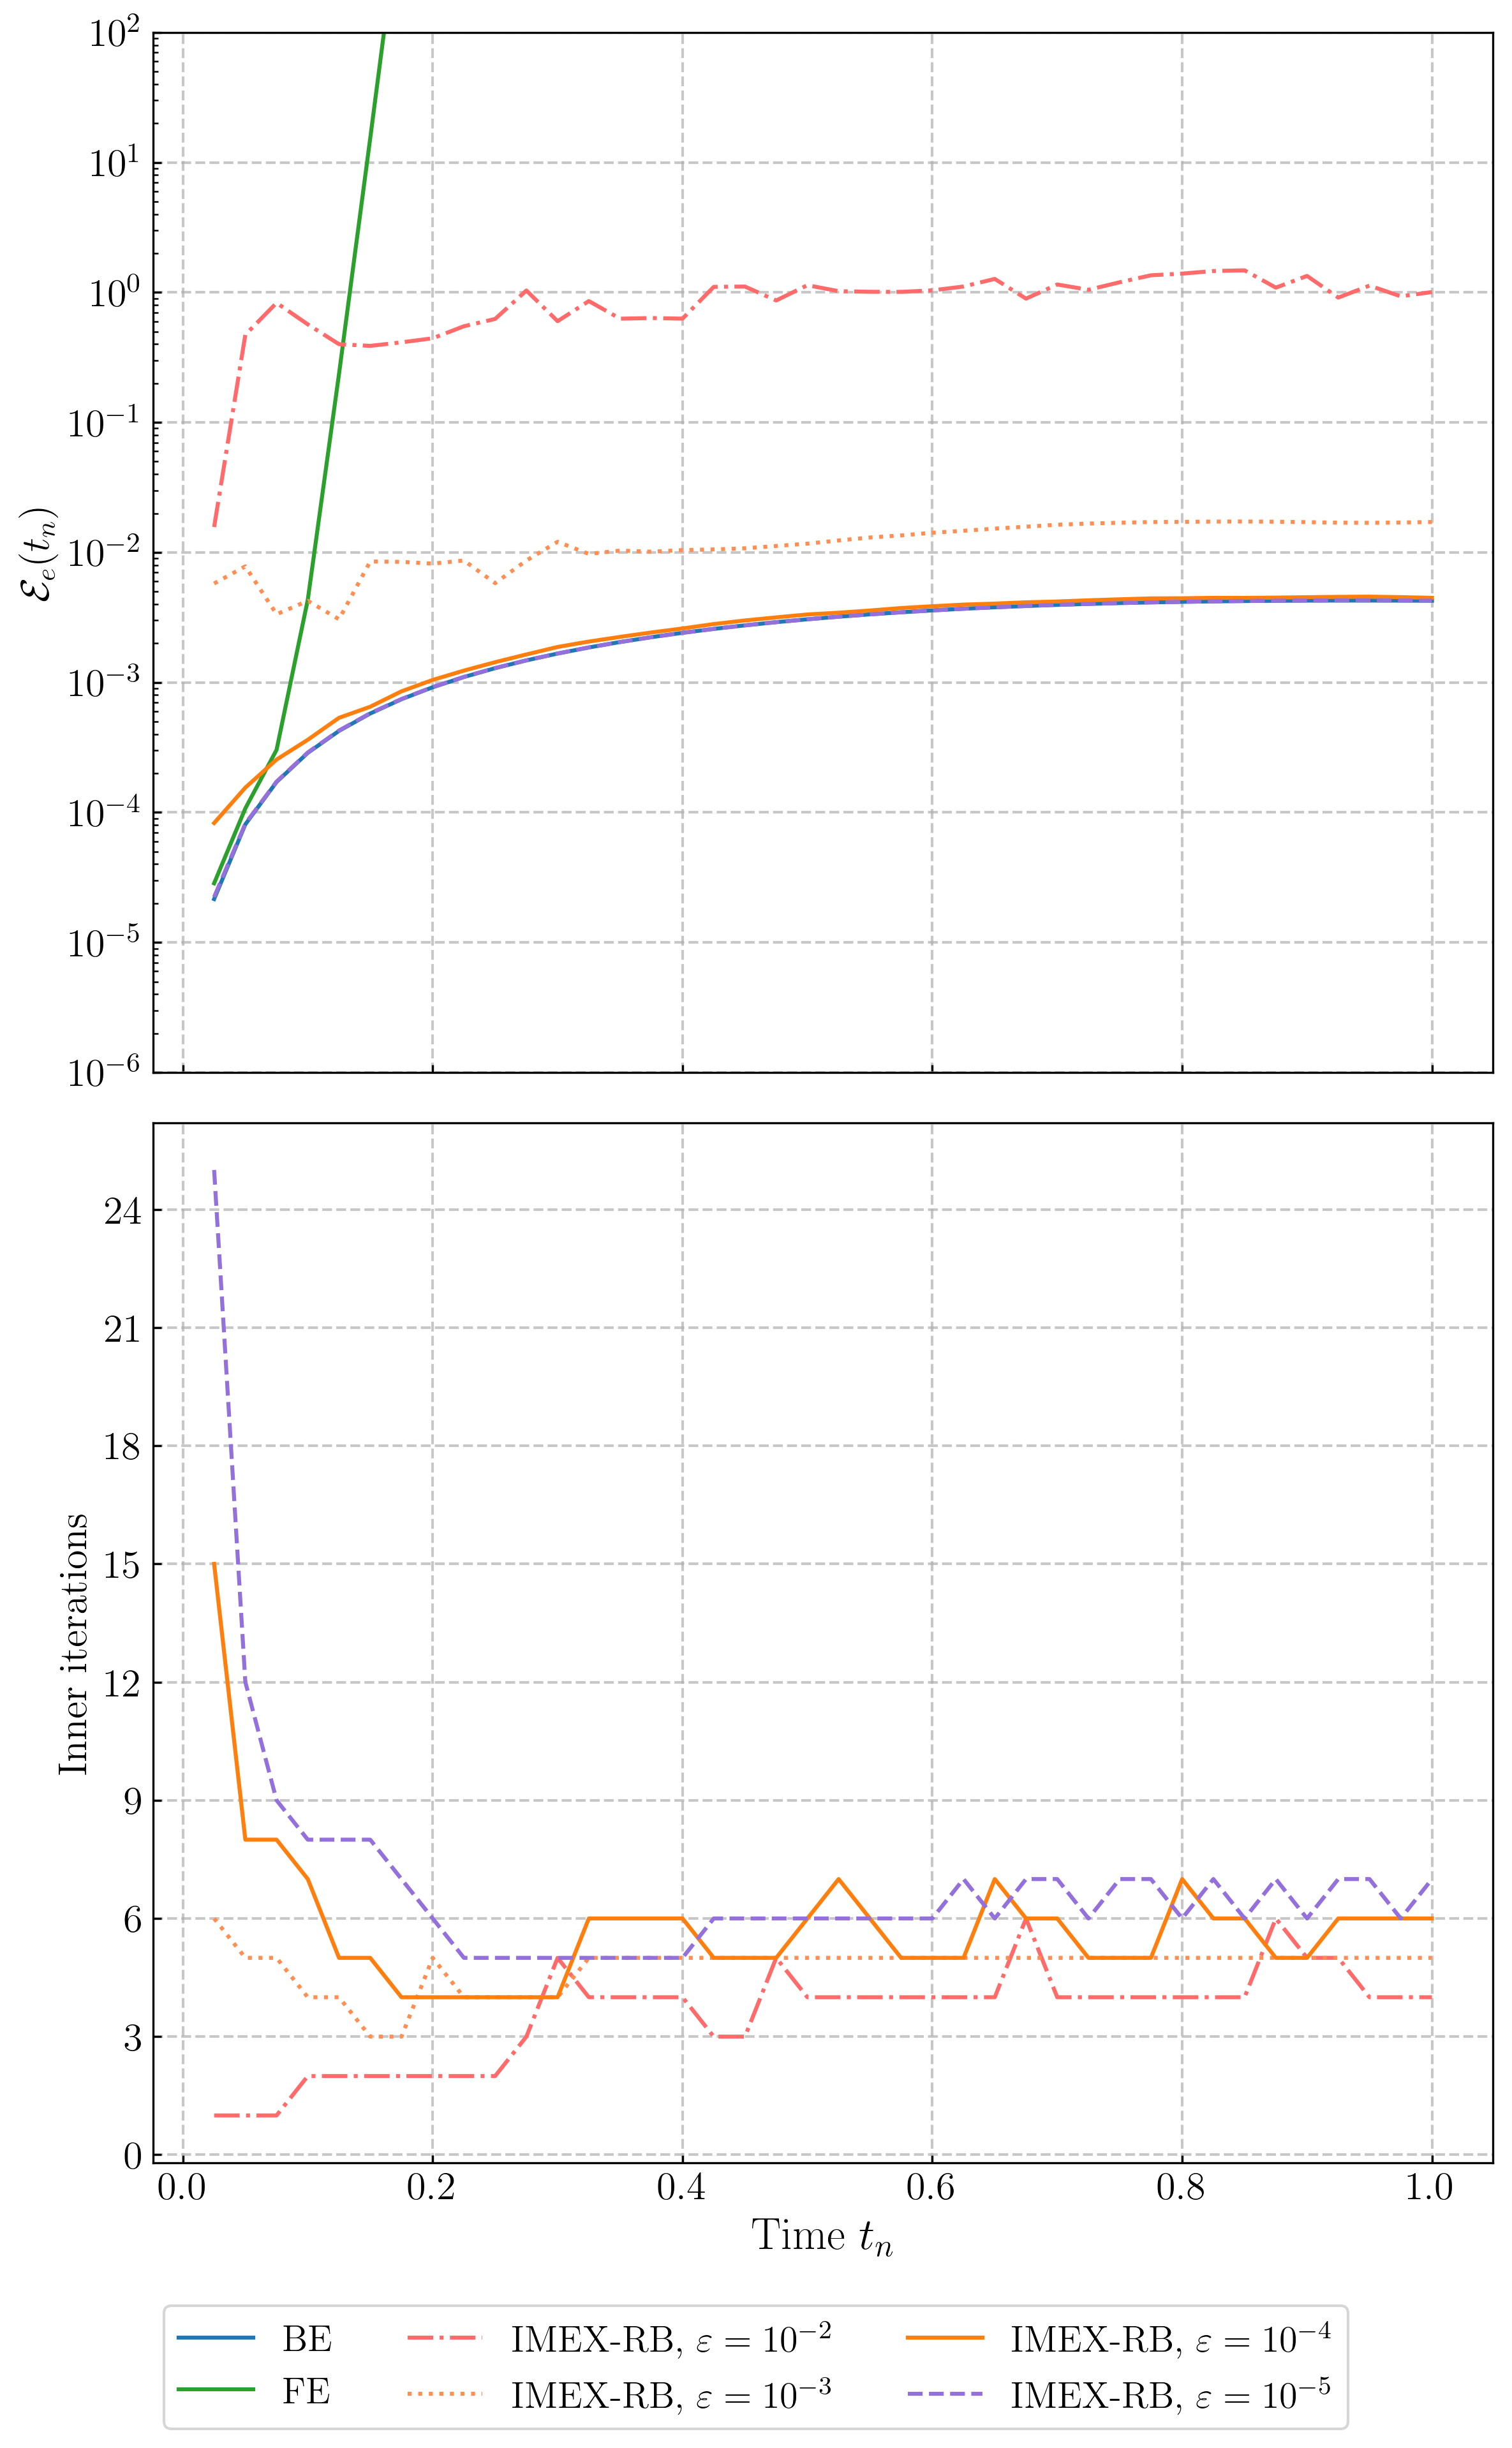

In [7]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1.5

colors = {
    'blue': '#1f77b4',
    'green': 'tab:green'
}
eps_colors = ['#ff6b6b', '#ff8e53', 'tab:orange', 'mediumpurple']

base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = "Burgers2D"
test_name = "energynorm"
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_energy = data['errors_energy'].item()
inneriters = data['inneriters'].item()['IMEX-RB'] + 1
Nt = int(data['Nt'])
tvec = np.linspace(0, 1, Nt + 1)
epsilon_values = data['epsilon_values']

linestyles = ['-.', ':', '-', '--']
method_colors = {'BE': colors['blue'], 'FE': colors['green']}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Top: energy error
for m in ('BE', 'FE'):
    e = errors_energy[m]
    ax1.semilogy(tvec[1:], e, linestyle='-', color=method_colors[m], label=f'{m}')

for ie, eps in enumerate(epsilon_values):
    e = errors_energy['IMEX-RB'][ie]
    ax1.semilogy(
        tvec[1:], e,
        linestyle=linestyles[ie],
        color=eps_colors[ie],
        label=''
    )

ax1.set_ylabel(r'$\mathcal{E}_e(t_n)$', fontsize=15)
ax1.set_ylim(1e-6, 1e2)
ax1.grid(which='major', linestyle='--', linewidth=1)
ax1.tick_params(axis='both', which='major', labelsize=15)

# Bottom: inner iterations
for ie, eps in enumerate(epsilon_values):
    expnt = int(np.log10(eps))
    label = rf'IMEX-RB, $\varepsilon=10^{{{expnt}}}$'
    its = inneriters[ie]
    ax2.plot(
        tvec[1:], its,
        linestyle=linestyles[ie],
        color=eps_colors[ie],
        label=label
    )

ax2.set_xlabel('Time $t_n$', fontsize=17)
ax2.set_ylabel('Inner iterations', fontsize=15)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(which='major', linestyle='--', linewidth=1)
ax2.tick_params(axis='both', which='major', labelsize=15)

# External legend
fig.legend(
    bbox_to_anchor=(0.5, -0.07),
    loc='lower center',
    ncol=3,
    fontsize=14
)

plt.tight_layout()
out_file = os.path.join(plots_dir, 'Burgers2D_errors_inneriters_eps.pdf')
plt.savefig(out_file, bbox_inches='tight')
plt.show()
plt.close()
